In [1]:
#import libraries
import re
import string
import nltk
import pandas as pd
import numpy as np
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset 
df = pd.read_csv('./Datasets/spam.csv', encoding=('ISO-8859-1'),low_memory=False)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#checkig shape of dataset
df.shape

(5572, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
#Rename columns1=v1 and columns2=v2
df = df[["v1", "v2"]]

In [6]:
df = df.rename(columns={'v2': 'messages', 'v1': 'label'})

In [7]:
df.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#checking null values
df.isnull()

,label,messages
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
5567,False,False
5568,False,False
5569,False,False
5570,False,False


In [9]:
df.isnull().sum()

label       0
messages    0
dtype: int64

In [10]:
#Encode the label column
enc = LabelEncoder()
enc.fit_transform(df['label'])

array([0, 0, 1, ..., 0, 0, 0])

In [11]:
df['label'] = enc.fit_transform(df['label'])
df.head()

,label,messages
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

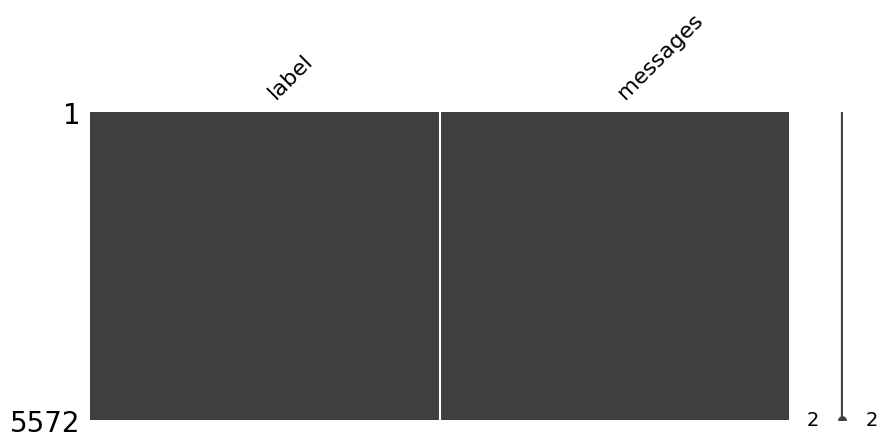

In [12]:
#plot matrix of label and messages
msn.matrix(df, figsize=(10,4))

<Axes: >

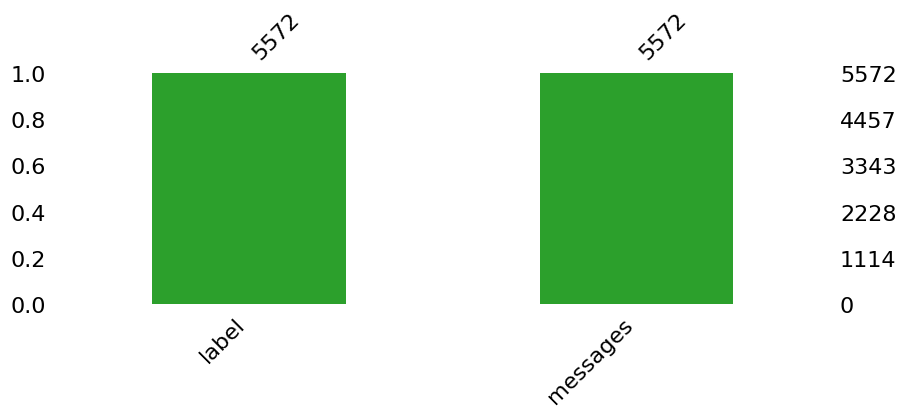

In [13]:
#plot bar of label and messages
msn.bar(df, figsize=(10,3),color="tab:green")

In [14]:
#Checking duplicate
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5567    False
5568    False
5569    False
5570    False
5571    False
Length: 5572, dtype: bool

In [15]:
df.duplicated().sum()

403

In [16]:
#drop the duplicate
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

<Axes: xlabel='label', ylabel='count'>

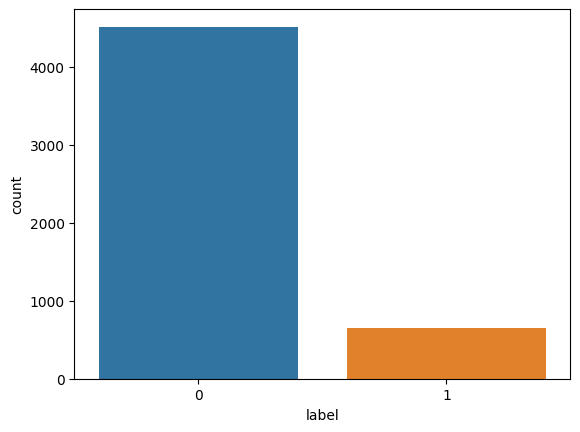

In [17]:
#visualized label columns
sns.countplot(x='label', data=df)

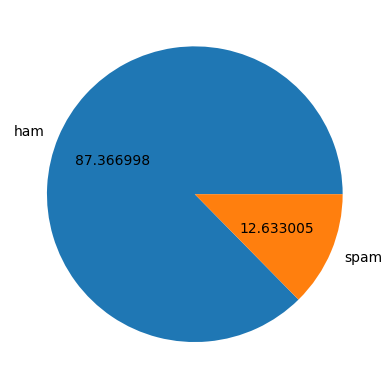

In [18]:
#showing ham and spam in label
plt.pie(df['label'].value_counts(), labels=['ham','spam'], autopct='%0.6f')
plt.show()

In [19]:
#Download the punkt package or checking for up to date 
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
#show massages
df['messages']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: messages, Length: 5169, dtype: object

In [21]:
#calculate number of character
df['num_char'] = df['messages'].apply(len)
df.head()

,label,messages,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
#tokenized
df['messages'].apply(lambda x: nltk.word_tokenize(x))

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: messages, Length: 5169, dtype: object

In [23]:
#calculate lenght of tokenized word 
df['messages'].apply(lambda x: len(nltk.word_tokenize(x)))

0       24
1        8
2       37
3       13
4       15
        ..
5567    35
5568     9
5569    15
5570    27
5571     7
Name: messages, Length: 5169, dtype: int64

In [24]:
#show word tokenized lenght in num_words then include in dataframe
df['num_words'] = df['messages'].apply(lambda x: len(nltk.word_tokenize(x)))
df.tail()

,label,messages,num_char,num_words
5567,1,This is the 2nd time we have tried 2 contact u...,161,35
5568,0,Will Ì_ b going to esplanade fr home?,37,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,15
5570,0,The guy did some bitching but I acted like i'd...,125,27
5571,0,Rofl. Its true to its name,26,7


In [25]:
# making num_sent. column then include in dataframe
df['num_sent.'] = df['messages'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.tail()

,label,messages,num_char,num_words,num_sent.
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1
5571,0,Rofl. Its true to its name,26,7,2


In [26]:
df['messages'].apply(lambda x: len(nltk.word_tokenize(x)))

0       24
1        8
2       37
3       13
4       15
        ..
5567    35
5568     9
5569    15
5570    27
5571     7
Name: messages, Length: 5169, dtype: int64

In [27]:
#describe the dataframe on label0
df[['num_char','num_words','num_sent.']][df['label']==0].describe()

,num_char,num_words,num_sent.
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [28]:
#describe the dataframe on label1
df[['num_char','num_words','num_sent.']][df['label']==1].describe()

,num_char,num_words,num_sent.
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: ylabel='num_char'>

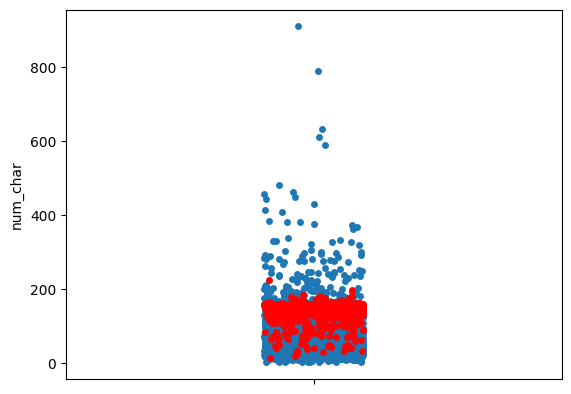

In [29]:
#show label0 and label1
sns.stripplot(df[df['label']==0]['num_char'])
sns.stripplot(df[df['label']==1]['num_char'], color='red')

<Axes: ylabel='num_words'>

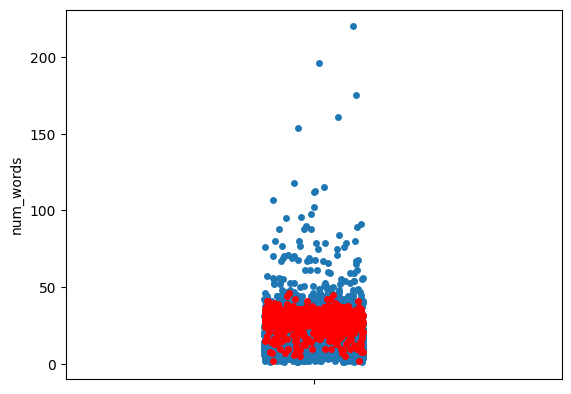

In [30]:
#show label0 and label1(num_words)
sns.stripplot(df[df['label']==0]['num_words'])
sns.stripplot(df[df['label']==1]['num_words'], color='red')

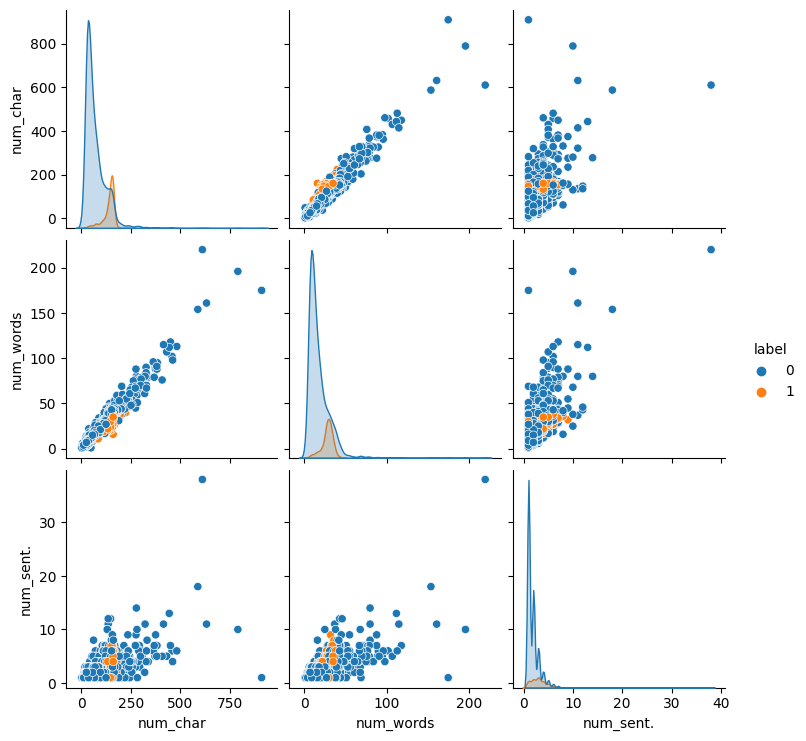

In [31]:
sns.pairplot(df, hue='label')

<Axes: >

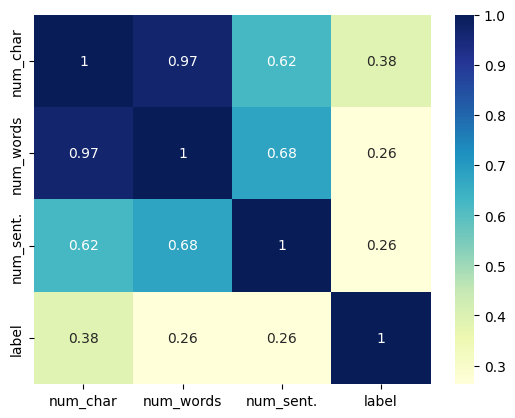

In [32]:
sns.heatmap(df[['num_char','num_words','num_sent.','label']].corr(),cmap="YlGnBu",annot=True)

<Axes: xlabel='num_char', ylabel='num_words'>

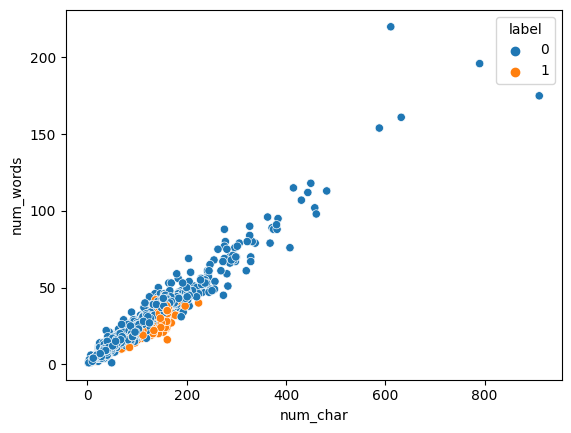

In [33]:
sns.scatterplot(x='num_char',y='num_words',data=df, hue='label')

In [34]:
#download stopwords package
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [35]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
ps = PorterStemmer()
ps.stem('writting')

'writ'

In [37]:
def transform_messages(messages):
    
    messages = messages.lower()
    messages = nltk.word_tokenize(messages)
    
    y = []
    
    for i in messages:
        if i.isalnum():
            y.append(i)
            
    messages = y[:]
    y.clear()
    
    for i in messages:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    messages = y[:]
    y.clear()
    
    for i in messages:
        y.append(ps.stem(i))
    return " ".join(y)

In [38]:
transform_messages('This is SAAD ALI here, and we the partners done the Machine Learning project1267, what About you? idno: ##$#$%%')

'saad ali partner done machin learn project1267 idno'

In [39]:
#convert into tranformed messages then include in dataframe
df['transformed_messages'] = df['messages'].apply(transform_messages)

In [40]:
df.head()

,label,messages,num_char,num_words,num_sent.,transformed_messages
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [41]:
#show into virtual image representation of word data 
wc = WordCloud(width=500,height=500,min_font_size=15,background_color='White')

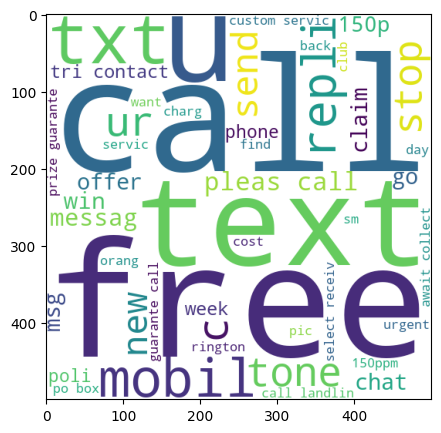

In [42]:
spam_wc = wc.generate(df[df['label'] == 1]['transformed_messages'].str.cat(sep=" "))
plt.figure(figsize=(10,5))
plt.imshow(spam_wc)
plt.show()

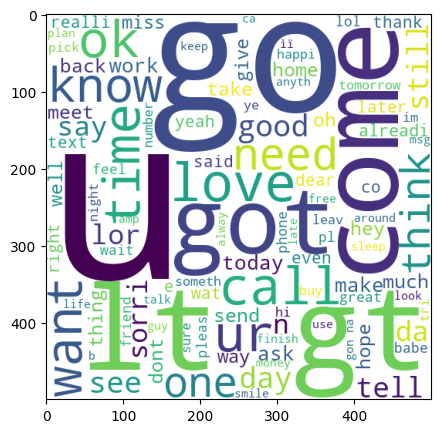

In [43]:
ham_wc = wc.generate(df[df['label'] == 0]['transformed_messages'].str.cat(sep=" "))
plt.figure(figsize=(10,5))
plt.imshow(ham_wc)
plt.show()

In [44]:
df[df['label']==1]

,label,messages,num_char,num_words,num_sent.,transformed_messages
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
5,1,FreeMsg Hey there darling it's been 3 week's n...,148,39,4,freemsg hey darl 3 week word back like fun sti...
8,1,WINNER!! As a valued network customer you have...,158,32,5,winner valu network custom select receivea pri...
9,1,Had your mobile 11 months or more? U R entitle...,154,31,3,mobil 11 month u r entitl updat latest colour ...
11,1,"SIX chances to win CASH! From 100 to 20,000 po...",136,31,3,six chanc win cash 100 pound txt csh11 send co...
...,...,...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,90,18,3,want explicit sex 30 sec ring 02073162414 cost...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,38,6,ask 3mobil 0870 chatlin inclu free min india c...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,160,35,5,contract mobil 11 mnth latest motorola nokia e...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,147,30,1,remind o2 get pound free call credit detail gr...


In [45]:
#listed the tranformed messages
df[df['label']==1]['transformed_messages'].to_list()

['free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18',
 'freemsg hey darl 3 week word back like fun still tb ok xxx std chg send rcv',
 'winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour',
 'mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030',
 'six chanc win cash 100 pound txt csh11 send cost 6day tsandc appli repli hl 4 info',
 'urgent 1 week free membership prize jackpot txt word claim 81010 c lccltd pobox 4403ldnw1a7rw18',
 'xxxmobilemovieclub use credit click wap link next txt messag click http',
 'england v macedonia dont miss news txt ur nation team 87077 eg england 87077 tri wale scotland poboxox36504w45wq',
 'thank subscript rington uk mobil charg pleas confirm repli ye repli charg',
 '07732584351 rodger burn msg tri call repli sm free nokia mobil free camcord pleas call 08000930705 deliveri tomorrow',
 '

In [46]:
spam_corpus= []

for msg in df[df['label']==1]['transformed_messages']:
    for word in msg.split():
        spam_corpus.append(word)

In [47]:
#spam words
spam_corpus

['free',
 'entri',
 '2',
 'wkli',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 'text',
 'fa',
 '87121',
 'receiv',
 'entri',
 'question',
 'std',
 'txt',
 'rate',
 'c',
 'appli',
 '08452810075over18',
 'freemsg',
 'hey',
 'darl',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chg',
 'send',
 'rcv',
 'winner',
 'valu',
 'network',
 'custom',
 'select',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobil',
 '11',
 'month',
 'u',
 'r',
 'entitl',
 'updat',
 'latest',
 'colour',
 'mobil',
 'camera',
 'free',
 'call',
 'mobil',
 'updat',
 'co',
 'free',
 '08002986030',
 'six',
 'chanc',
 'win',
 'cash',
 '100',
 'pound',
 'txt',
 'csh11',
 'send',
 'cost',
 '6day',
 'tsandc',
 'appli',
 'repli',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'prize',
 'jackpot',
 'txt',
 'word',
 'claim',
 '81010',
 'c',
 'lccltd',
 'pobox',
 '4403ldnw

In [48]:
len(spam_corpus)

9939

In [49]:
Counter(spam_corpus)

Counter({'free': 191,
         'entri': 21,
         '2': 155,
         'wkli': 9,
         'comp': 8,
         'win': 48,
         'fa': 2,
         'cup': 3,
         'final': 14,
         'tkt': 2,
         '21st': 1,
         'may': 6,
         'text': 122,
         '87121': 2,
         'receiv': 31,
         'question': 9,
         'std': 6,
         'txt': 141,
         'rate': 26,
         'c': 45,
         'appli': 24,
         '08452810075over18': 1,
         'freemsg': 14,
         'hey': 5,
         'darl': 2,
         '3': 20,
         'week': 49,
         'word': 21,
         'back': 20,
         'like': 12,
         'fun': 8,
         'still': 5,
         'tb': 1,
         'ok': 5,
         'xxx': 10,
         'chg': 2,
         'send': 60,
         'rcv': 2,
         'winner': 13,
         'valu': 8,
         'network': 26,
         'custom': 42,
         'select': 26,
         'receivea': 1,
         'prize': 82,
         'reward': 9,
         'claim': 98,
         'cal

In [50]:
Counter(spam_corpus).most_common(30)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

In [51]:
#most comman spam word
pd.DataFrame(Counter(spam_corpus).most_common(30))

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


In [52]:
df[df['label']==0]['transformed_messages'].to_list()

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'even brother like speak treat like aid patent',
 'per request mell oru minnaminungint nurungu vettam set callertun caller press 9 copi friend callertun',
 'gon na home soon want talk stuff anymor tonight k cri enough today',
 'search right word thank breather promis wont take help grant fulfil promis wonder bless time',
 'date sunday',
 'oh k watch',
 'eh u rememb 2 spell name ye v naughti make v wet',
 'fine thatåõ way u feel thatåõ way gota b',
 'serious spell name',
 'go tri 2 month ha ha joke',
 'pay first lar da stock comin',
 'aft finish lunch go str lor ard 3 smth lor u finish ur lunch alreadi',
 'ffffffffff alright way meet sooner',
 'forc eat slice realli hungri tho suck mark get worri know sick turn pizza lol',
 'lol alway convinc',
 'catch bu fri egg make tea eat mom left dinner feel love

In [53]:
ham_corpus = []

for msg in df[df['label']==0]['transformed_messages'].to_list():
    for word in msg.split():
        ham_corpus.append(word)

In [54]:
ham_corpus


['go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amor',
 'wat',
 'ok',
 'lar',
 'joke',
 'wif',
 'u',
 'oni',
 'u',
 'dun',
 'say',
 'earli',
 'hor',
 'u',
 'c',
 'alreadi',
 'say',
 'nah',
 'think',
 'goe',
 'usf',
 'live',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aid',
 'patent',
 'per',
 'request',
 'mell',
 'oru',
 'minnaminungint',
 'nurungu',
 'vettam',
 'set',
 'callertun',
 'caller',
 'press',
 '9',
 'copi',
 'friend',
 'callertun',
 'gon',
 'na',
 'home',
 'soon',
 'want',
 'talk',
 'stuff',
 'anymor',
 'tonight',
 'k',
 'cri',
 'enough',
 'today',
 'search',
 'right',
 'word',
 'thank',
 'breather',
 'promis',
 'wont',
 'take',
 'help',
 'grant',
 'fulfil',
 'promis',
 'wonder',
 'bless',
 'time',
 'date',
 'sunday',
 'oh',
 'k',
 'watch',
 'eh',
 'u',
 'rememb',
 '2',
 'spell',
 'name',
 'ye',
 'v',
 'naughti',
 'make',
 'v',
 'wet',
 'fine',
 'thatåõ',
 'wa

In [55]:
Counter(ham_corpus).most_common(30) 

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('call', 233),
 ('time', 219),
 ('ok', 217),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165),
 ('lor', 159),
 ('4', 156),
 ('home', 152),
 ('think', 149),
 ('see', 147),
 ('take', 143),
 ('still', 143),
 ('da', 142),
 ('tell', 133),
 ('make', 129)]

In [56]:
#most common ham words
pd.DataFrame(Counter(ham_corpus).most_common(30))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


In [57]:
tfid = TfidfVectorizer(max_features=3000)

In [58]:
#convert into array
X = tfid.fit_transform(df['transformed_messages']).toarray()

In [59]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
X.shape

(5169, 3000)

In [61]:
y = df['label'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [62]:
#test and trainning data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=2)

In [63]:
#model is used
BNB = BernoulliNB()
GNB = GaussianNB()
MNB = MultinomialNB()
LR = LogisticRegression()
KNN = KNeighborsClassifier()
DTC = DecisionTreeClassifier(max_depth=5)
svc = SVC(kernel='sigmoid',gamma=0.1) 

In [64]:
BNB.fit(X_train,y_train)
y_pred_BNB = BNB.predict(X_test)
Accuracy1 = accuracy_score(y_test,y_pred_BNB)
Confusion_Matrix1 =confusion_matrix(y_test,y_pred_BNB)
Precision_Score1 = precision_score(y_test,y_pred_BNB) 

In [65]:
GNB.fit(X_train,y_train)
y_pred_GNB = GNB.predict(X_test)
Accuracy2 = accuracy_score(y_test,y_pred_GNB)
Confusion_Matrix2 = confusion_matrix(y_test,y_pred_GNB)
Precision_Score2 = precision_score(y_test,y_pred_GNB)

In [66]:
MNB.fit(X_train,y_train)
y_pred_MNB = MNB.predict(X_test)
Accuracy3 = accuracy_score(y_test,y_pred_MNB)
Confusion_Matrix3 = confusion_matrix(y_test,y_pred_MNB)
Precision_Score3 = precision_score(y_test,y_pred_MNB)

In [67]:
LR.fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)
Accuracy4 = accuracy_score(y_test,y_pred_LR)
Confusion_Matrix4 = confusion_matrix(y_test,y_pred_LR)
Precision_Score4 = precision_score(y_test,y_pred_LR)

In [68]:
KNN.fit(X_train,y_train)
y_pred_KNN = KNN.predict(X_test)
Accuracy5 = accuracy_score(y_test,y_pred_KNN)
Confusion_Matrix5 = confusion_matrix(y_test,y_pred_KNN)
Precision_Score5 = precision_score(y_test,y_pred_KNN)

In [69]:
DTC.fit(X_train,y_train)
y_pred_DTC = DTC.predict(X_test)
Accuracy6 = accuracy_score(y_test,y_pred_DTC)
Confusion_Matrix6 = confusion_matrix(y_test,y_pred_DTC)
Precision_Score6 = precision_score(y_test,y_pred_DTC)

In [70]:
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
Accuracy7 = accuracy_score(y_test,y_pred_svc)
Confusion_Matrix7 = confusion_matrix(y_test,y_pred_svc)
Precision_Score7 = precision_score(y_test,y_pred_svc)

In [71]:
results = pd.DataFrame({
    'Model': ['BernoulliNB','GaussianNB','MultinomialNB','Logistic Regression','KNN','DecisionTreeClassifier','Support Vector Machines'],
    'Score': [Accuracy1,Accuracy2,Accuracy3,Accuracy4,Accuracy5,Accuracy6,Accuracy7]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
0.983559,BernoulliNB
0.970986,MultinomialNB
0.956480,Logistic Regression
0.929400,Support Vector Machines
0.927466,DecisionTreeClassifier
0.905222,KNN
0.869439,GaussianNB


Text(0.5, 1.0, 'Score')

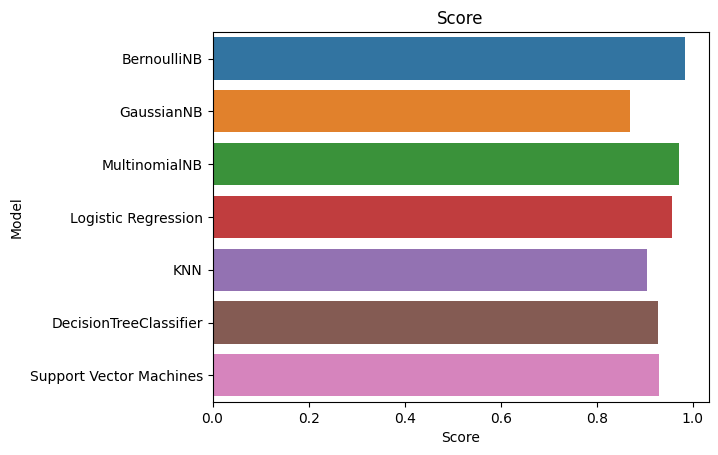

In [72]:
sns.barplot(x='Score', y='Model', data = results)
plt.ylabel('Model')
plt.title('Score')

In [73]:
results1 = pd.DataFrame({
    'Model': ['BernoulliNB','GaussianNB','MultinomialNB','Logistic Regression','KNN','DecisionTreeClassifier','Support Vector Machines'],
    'Score': [Precision_Score1,Precision_Score2,Precision_Score3,Precision_Score4,Precision_Score5,Precision_Score6,Precision_Score7]})
result_df = results1.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
1.000000,MultinomialNB
1.000000,KNN
0.991870,BernoulliNB
0.979381,Logistic Regression
0.971014,Support Vector Machines
0.811881,DecisionTreeClassifier
0.506849,GaussianNB


Text(0.5, 1.0, 'Score')

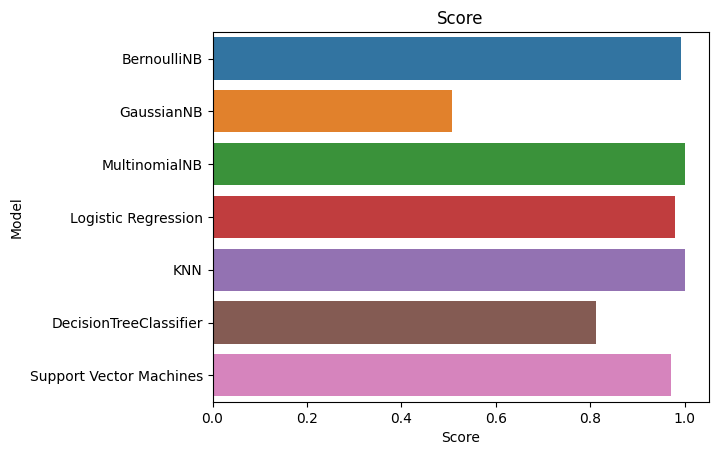

In [74]:
sns.barplot(x='Score', y='Model', data = results1)
plt.ylabel('Model')
plt.title('Score')